<a href="https://colab.research.google.com/github/bilmark0/Deep-Learning-alpjai-Main-Project/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imprting data and initial data procession

In [1]:
# Install kaggle library
!pip install kaggle

In [2]:
from google.colab import files
import zipfile
import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random
import cv2

In [3]:
# Ask the user to upload their kaggle.json file to download the data
uploaded = files.upload()

# Move the uploaded kaggle.json file to the proper directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [4]:
# Download the training data from kaggle
!kaggle competitions download -c airbus-ship-detection

# Unzip the file and delete the zip afterwards in order to save spaece
zip_file = '/content/airbus-ship-detection.zip'
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall()
os.remove(zip_file)
if os.path.exists('/content/sample_data'):
  shutil.rmtree('/content/sample_data')

print("Download and extraction complete.")

100% 28.6G/28.6G [06:17<00:00, 40.5MB/s]
100% 28.6G/28.6G [06:17<00:00, 81.2MB/s]
Download and extraction complete.


#Data procession

### First we just analyse the distribution of the pictures based on the number of ships. The reason for this is that we will find unnecesarly large amount of pics with 0 ships. Later on we will filter the data based on this to make the traning process faster and simpler. (Traning section)

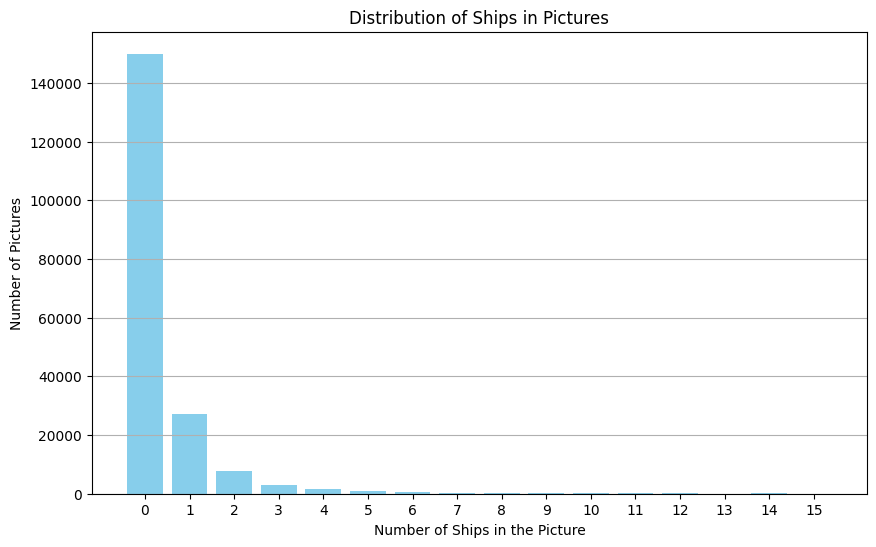

The picture with the most ships is '01914baf2.jpg' with 15 ships.


In [5]:
# Set path to the .csv file containig the output rle-s
csv_path = '/content/train_ship_segmentations_v2.csv'

# Functio to count how many ships does each picture contains
def count_ships(csv_path):
    df = pd.read_csv(csv_path, header=None, skiprows=1)

    # Create a dictionary to count ships per filename
    ship_count = {}

    # Iterate through the DataFrame
    for index, row in df.iterrows():
        filename = row[0]  # Picture filename
        rle = row[1]  # RLE encoded map

        # Only process if the filename is a string and is not NaN
        if isinstance(filename, str) and filename.strip():
            if filename not in ship_count:
                ship_count[filename] = 0  # Initialize count for the filename

            # If RLE is not empty (and is a string), increment the ship count for this filename
            if isinstance(rle, str) and rle.strip():  # If there is an RLE code, it means there is at least one ship
                ship_count[filename] += 1

    # Count how many pictures have 0, 1, 2, etc. ships
    ship_distribution = {}
    for count in ship_count.values():
        if count not in ship_distribution:
            ship_distribution[count] = 0
        ship_distribution[count] += 1  # Count the occurrences of each ship count

    return ship_count, ship_distribution  # Return both dictionaries

def plot_ship_distribution(ship_distribution):
    # Prepare data for plotting
    counts = list(ship_distribution.keys())
    num_pictures = list(ship_distribution.values())

    # Create a histogram
    plt.figure(figsize=(10, 6))
    plt.bar(counts, num_pictures, color='skyblue')
    plt.xlabel('Number of Ships in the Picture')
    plt.ylabel('Number of Pictures')
    plt.title('Distribution of Ships in Pictures')
    plt.xticks(counts) #number of ships
    plt.grid(axis='y')
    plt.show()

# Function to find the picture with the maximum number of ships just for a funfact
def find_max_ships_picture(ship_count):
    max_ships = -1
    max_picture = None

    for filename, count in ship_count.items():
        if count > max_ships:
            max_ships = count
            max_picture = filename

    return max_picture, max_ships

# Count ships and plot the distribution
ship_count, ship_distribution = count_ships(csv_path)
plot_ship_distribution(ship_distribution)

max_picture, max_ships = find_max_ships_picture(ship_count)

print(f"The picture with the most ships is '{max_picture}' with {max_ships} ships.")


##Building the dataset for traning

In [6]:
# Load the .csv file, skipping the first row for safety
df = pd.read_csv('/content/train_ship_segmentations_v2.csv', skiprows=1, header=None, names=['filename', 'rle_data'])

# Convert RLE data to string, replacing NaN with an empty string
df['rle_data'] = df['rle_data'].astype(str).replace('nan', '')

# Group by filename and combine the RLE data, so that every picture only has one RLE output containing all the information
combined_df = df.groupby('filename')['rle_data'].apply(lambda x: ' '.join(x)).reset_index()

# Save the combined data to a new CSV file
combined_df.to_csv('combined_rle_data.csv', index=False)


###*This* segment creates the output images from the rle data in the .csv file

In [7]:
csv_path = '/content/combined_rle_data.csv'
output_folder = '/content/rle_images'
os.makedirs(output_folder, exist_ok=True)

# Function to decode the rle codes for output data visualization
def rle_decode(rle, height, width):
    # Decodes the RLE encoded string into a binary mask (image) filled column by column.
    rle = list(map(int, rle.split()))
    img = np.zeros((height, width), dtype=np.uint8)  # Create an empty 2D array

    for start, length in zip(rle[::2], rle[1::2]):
        # Calculate column and row based on column-major order
        col_start = start // height  # Column index
        row_start = start % height    # Row index within that column

        for i in range(length):
            # Fill the pixel in column-major order
            img[(row_start + i) % height, col_start] = 255  # Update the corresponding pixel

    return img

# Creates the output images from the rle data
def process_rle_images(csv_path, output_folder):
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    with open(csv_path, 'r') as file:
        # Skip the first row (header)
        next(file)

        # Process each line in the CSV
        for line in file:
            # Strip whitespace and split by comma
            parts = line.strip().split(',')
            if len(parts) != 2:
                print(f"Skipping invalid line: {line.strip()}")
                continue  # Skip invalid lines

            filename, rle = parts
            filename = filename.strip()
            rle = rle.strip()

            # Decode the RLE into a 768x768 image
            img_data = rle_decode(rle, height=768, width=768)

            # Create an image from the array
            img = Image.fromarray(img_data, mode='L')  # 'L' mode for grayscale

            img.save(os.path.join(output_folder, filename))

# Process the images from RLE
process_rle_images(csv_path, output_folder)

In [8]:
# Set path to the .csv file containig the output rle-s
csv_path = '/content/train_ship_segmentations_v2.csv'

df = pd.read_csv(csv_path, header=None, skiprows=1)

# Initialize a dictionary to hold counts
ship_count = {}

# Iterate through each picture
for index, row in df.iterrows():
    filename = row[0]  # Picture filename
    rle = row[1]  # RLE encoded map

    # Only process if the filename is a string and is not NaN
    if isinstance(filename, str) and filename.strip():
        if filename not in ship_count:
            ship_count[filename] = {'count': 0, 'has_rle': False}

        # Count occurrences
        ship_count[filename]['count'] += 1

        # Check if there is an RLE code (indicating a ship is present)
        if isinstance(rle, str) and rle.strip():  # If there is an RLE code
            ship_count[filename]['has_rle'] = True

# Finalize the ship counts based on occurrences and presence of RLE
final_ship_count = {filename: (data['count'] if data['has_rle'] else 0) for filename, data in ship_count.items()}

dir1 = '/content/rle_images'
dir2 = '/content/train_v2'

#paring image names to ship counts

# List of files in both directories
files_dir1 = set(os.listdir(dir1))
files_dir2 = set(os.listdir(dir2))

# Find the common files between the two directories
common_files = files_dir1.intersection(files_dir2)

# Create a list to store the image pairs and counts
image_pairs = []
total_pairs_found = 0  # Initialize a counter for pairs found

# Create pairs of images with ship count
for file_name in common_files:
    count = final_ship_count.get(file_name, 0)  # Get the count, default to 0 if not found
    image_pairs.append((file_name, count))
    total_pairs_found += 1  # Increment the counter for each pair found

# Print the total number of pairs found
print(f"\nTotal Pairs Found: {total_pairs_found}")



Total Pairs Found: 192556


###This segment will seperate the pictures into two different arrays, based on wether they contain ships or not.

In [9]:
def separate_filenames_by_ship_count(image_pairs):
    # Initialize arrays for images with and without ships
    images_with_ships = []
    images_without_ships = []

    # Separate images based on ship count
    for filename, count in image_pairs:
        if count > 0:
            images_with_ships.append((filename, count))  # Append to images with ships
        else:
            images_without_ships.append((filename, count))  # Append to images without ships

    return images_with_ships, images_without_ships

# Call the function
with_ships, without_ships = separate_filenames_by_ship_count(image_pairs)

# Output the results
print("Images with ships:", len(with_ships))
print("Images without ships:", len(without_ships))


Images with ships: 42556
Images without ships: 150000


The following code will show 5 samples of how the mask looks like after decoding it into 768x768 pictures. The purple color masked over the original picture is the RLE encoded pixels of the mask. If for some reason the picture loading fails the program will give an error message. (Running this code segment multiple times is enabled, it will just show 5 other pictures as samples)

Note: The samples shown are only selected from pictures that contain at least one ship

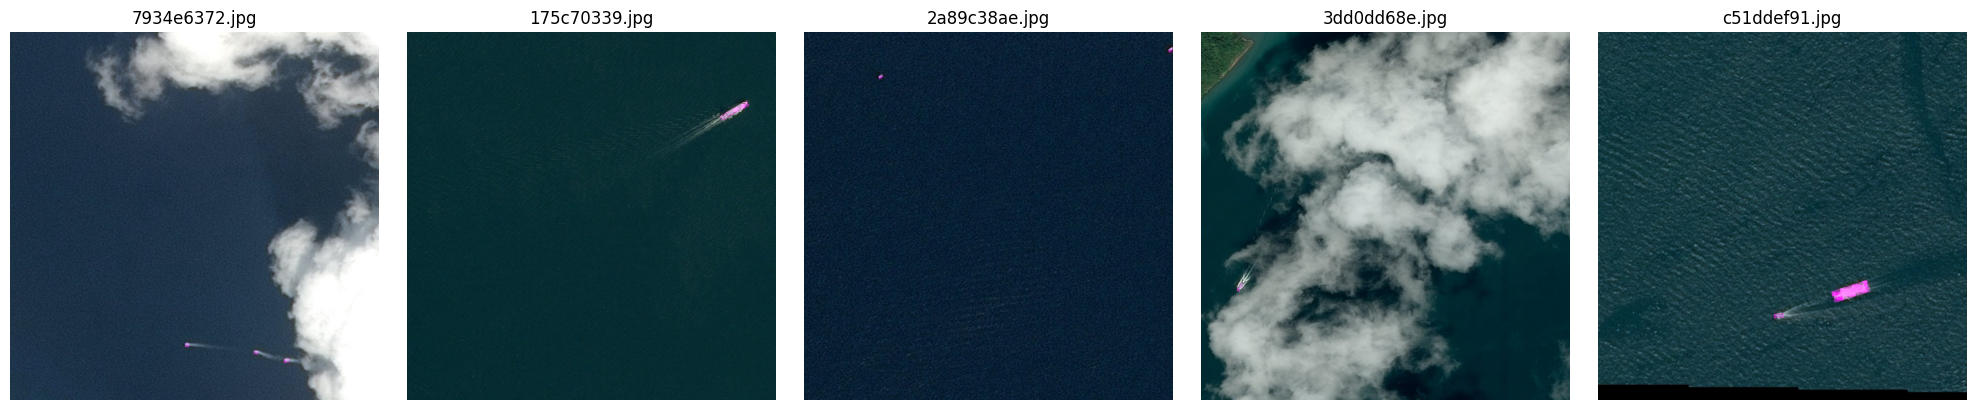

In [10]:
# Directories containing the images
dir_original = '/content/train_v2'  # Path to the original images
dir_rle = '/content/rle_images'       # Path to the RLE images

#Because we used different methods this was implemented
if isinstance(with_ships, np.ndarray):
    # Choose 5 random elements from the first column of the array
    selected_images = random.sample(list(with_ships[:, 0]), 5)  # Extract only the first column for filenames
else:
    # With_ships is a list containing filenames in the first position
    selected_images = random.sample([entry[0] for entry in with_ships], 5)

# Plot preparation:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i, image_name in enumerate(selected_images):
    # Load the original and RLE images
    original_path = os.path.join(dir_original, f"{image_name}")
    rle_path = os.path.join(dir_rle, f"{image_name}")

    original_image = cv2.imread(original_path)
    rle_image = cv2.imread(rle_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale

    # Check if images are loaded correctly
    if original_image is None:
        print(f"Error loading original image: {original_path}")
        continue
    if rle_image is None:
        print(f"Error loading RLE image: {rle_path}")
        continue

    # Create a binary mask
    binary_mask = (rle_image == 255).astype(np.uint8)  # 1 where white pixels, 0 where black pixels

    # Create an RGB mask with the desired color (magenta)
    color_mask = np.zeros_like(original_image, dtype=np.uint8)
    color_mask[binary_mask == 1] = [255, 0, 255]  # Assign magenta color to white regions

    # Apply the mask to the original image
    masked_image = cv2.addWeighted(original_image, 1, color_mask,1, 0)  # Blend the mask with the original image

    #Plot the masked image
    axes[i].imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
    axes[i].set_title(image_name)
    axes[i].axis('off')

plt.tight_layout()
plt.show()


#Training after hyperparameter optimisation (hyp opt is in another file. The best modell was imported and trained here)

## Boulding Traning, validation and test sets

In this code segment we wanted to make the dataset less assymetrical, because according to the histogram where we counted the number of ships on every picture, we could see that there are way more pictures without any, than there are with at least 1. There is a parameter in the beginning of the code that can change the amount of pictures with at least 1 ship, and the rest will be filled with randomly selected shipless pictures. (For example if the proportion is 0.7, it means that the main dataset will contain all the pictures with ships and it will fill 70% of the learning dataset, the remaining 30% is pictures without ships)

In [11]:
proportion = 0.7 #data% with ships
val_split = 0.01  # Proportion for validation
test_split = 0.0075  # Proportion for test

def merge_random_elements(with_ships, without_ships, proportion): #function to create the main traning dataset

    x = int(len(with_ships)/proportion*(1-proportion))
    # Shuffle the without_ships array
    random.shuffle(without_ships)

    # Take the first x elements from the shuffled without_ships array
    selected_without_ships = without_ships[:x]

    # Merge the selected elements with the with_ships array
    main_data = with_ships + selected_without_ships
    random.shuffle(main_data)

    return main_data

main_data = merge_random_elements(with_ships, without_ships, proportion) #when teaching the NN, these pictures will be used

val_size = int(len(main_data) * val_split)
test_size = int(len(main_data) * test_split)

val_data = main_data[:val_size]
test_data = main_data[val_size : val_size + test_size]
main_data = main_data[val_size + test_size:] #is also the traning data (has this name because it was used later and it would be a pain to rename elswhere)

# Sizes
print(f"Train size: {len(main_data)}")
print(f"Validation size: {len(val_data)}")
print(f"Test size: {len(test_data)}")
print(f"Whith ships in train: {len([x for x in main_data if x[1] > 0])}")
print(f"Without ships in train: {len([x for x in main_data if x[1] == 0])}")

#Note that we won't be loading the pictures into arrays because it will take unnecessary memory space and
#converting the pictures into arrays does not take significant time when teaching the network (this may not be exactly true, but dou to size limitations in colabe we will do this to be safe)

Train size: 59732
Validation size: 607
Test size: 455
Whith ships in train: 41820
Without ships in train: 17912


##Building the modell

Here we built the rcnn described in the documentation, with the relevant hyperparameters

In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os
import cv2
import numpy as np
import random

# Constant parameters (ofc when doing hyperparameterr opt the model may be optimised for them)
IMAGE_SIZE = (384, 384)
BATCH_SIZE = 4
EPOCHS = 1
NUM_CLASSES = 2  # Background and ships

# Data Generator to Load Images and Masks
def data_generator(main_data, image_dir, mask_dir, batch_size=BATCH_SIZE):
    while True:
        batch_data = random.sample(main_data, batch_size)
        images, masks = [], []

        for filename, _ in batch_data:
            img_path = os.path.join(image_dir, filename)
            mask_path = os.path.join(mask_dir, filename)

            # Load image and mask
            image = cv2.imread(img_path)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            # Check if images are loaded correctly
            if image is None:
                print(f"Error loading image: {img_path}")
                continue
            if mask is None:
                print(f"Error loading mask: {mask_path}")
                continue

            # Resize for uniformity
            image = cv2.resize(image, IMAGE_SIZE)
            mask = cv2.resize(mask, IMAGE_SIZE)

            # Normalize images and binary masks
            image = image.astype(np.float32) / 255.0
            mask = (mask > 0).astype(np.float32)  # Binary mask

            images.append(image)
            masks.append(mask)

        # Ensuring that the batch is complete
        if len(images) == 0:
            continue

        yield np.array(images), np.array(masks).reshape(-1, IMAGE_SIZE[0], IMAGE_SIZE[1], 1)

# Backbone: ResNet50 for feature extraction
def resnet50_backbone(input_shape):
    resnet50 = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)
    layer_names = ["conv2_block3_out", "conv3_block4_out", "conv4_block6_out"]
    outputs = [resnet50.get_layer(name).output for name in layer_names]
    return Model(inputs=resnet50.input, outputs=outputs)

def mask_head(roi_feature, num_classes=1):
    # Initial convolution
    x = Conv2D(256, (3, 3), padding="same", activation="relu")(roi_feature)

    # Deconvolution (Transpose Convolution) layers for upsampling
    x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding="same", activation="relu")(x)
    x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding="same", activation="relu")(x)
    x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding="same", activation="relu")(x)
    x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding="same", activation="relu")(x)

    # Final convolution to produce the mask output
    mask_output = Conv2D(num_classes, (1, 1), activation="sigmoid", name='mask_output')(x)
    return mask_output



# Build the Mask RCNN model (simplified to output only masks)
def build_mask_rcnn(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), num_classes=1):  # Binary mask
    input_img = Input(shape=input_shape, name='input_image')
    backbone = resnet50_backbone(input_shape)
    roi_feature = backbone(input_img)
    mask_output = mask_head(roi_feature[-1], num_classes)  # Use last feature layer
    model = Model(inputs=input_img, outputs=mask_output, name='Mask_RCNN_Simplified')
    return model


# Instantiate and compile the model
model = build_mask_rcnn()
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# visualizing the model
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "Mask_RCNN_Simplified"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 384, 384, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional (Functional)              │ [(None, 96, 96, 256),       │       8,589,184 │
│                                      │ (None, 48, 48, 512), (None, │                 │
│                                      │ 24, 24, 1024)]              │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 24, 24, 256)         │       2,359,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 48, 48, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 96, 96, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 192, 192, 256)       │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 384, 384, 256)       │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mask_output (Conv2D)                 │ (None, 384, 384, 1)         │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,309,313 (50.77 MB)

 Trainable params: 13,278,721 (50.65 MB)

 Non-trainable params: 30,592 (119.50 KB)

##Traning the modell

Initilazing the traning and saved the best modell.

In [13]:
# Callbacks
checkpoint = ModelCheckpoint('mask_rcnn_best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training
image_dir = '/content/train_v2'
mask_dir = '/content/rle_images'
train_gen = data_generator(main_data, image_dir, mask_dir)
val_steps_per_epoch = max(len(val_data) // BATCH_SIZE, 1)
val_gen = data_generator(val_data, image_dir, mask_dir)
# Calculate steps per epoch
steps_per_epoch = len(main_data) // BATCH_SIZE
if steps_per_epoch == 0:
    steps_per_epoch = 1  # Ensure at least one step per epoch

history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=val_steps_per_epoch,
    epochs=EPOCHS,
    callbacks=[checkpoint, early_stopping]
)

14933/14933 ━━━━━━━━━━━━━━━━━━━━ 5158s 340ms/step - accuracy: 0.9959 - loss: 0.0117 - val_accuracy: 0.9980 - val_loss: 0.0056


##Testing and solution vizualization

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


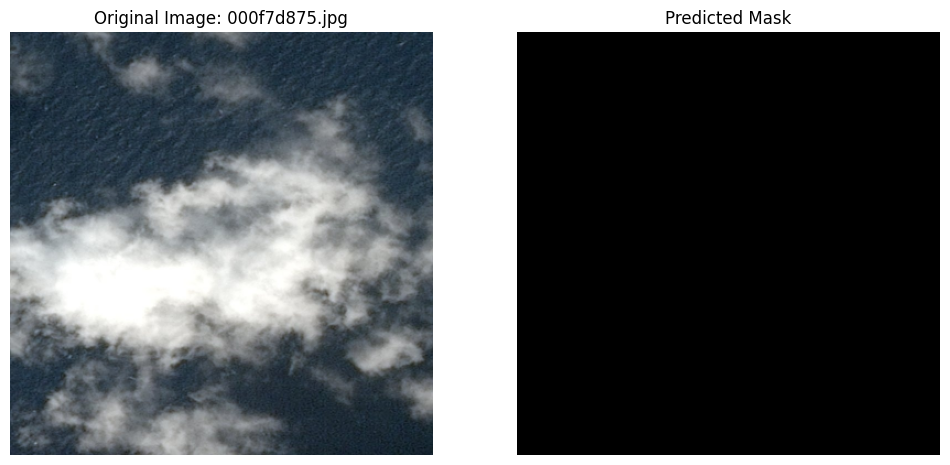

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


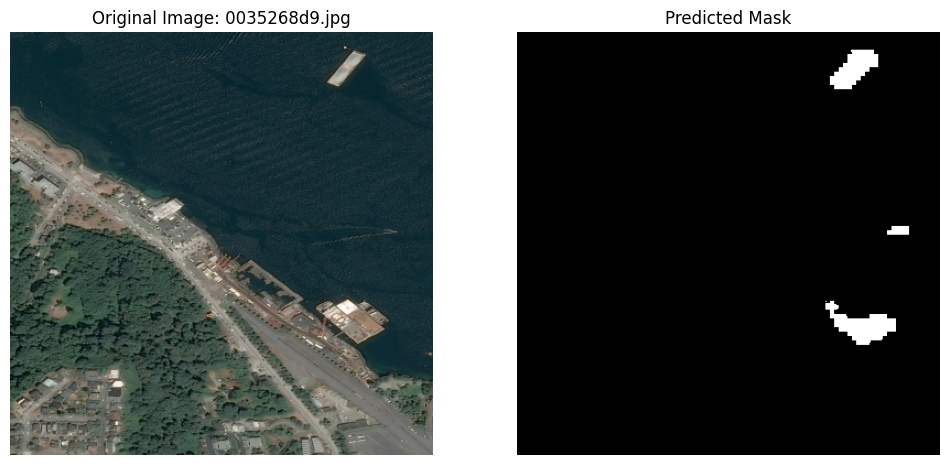

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


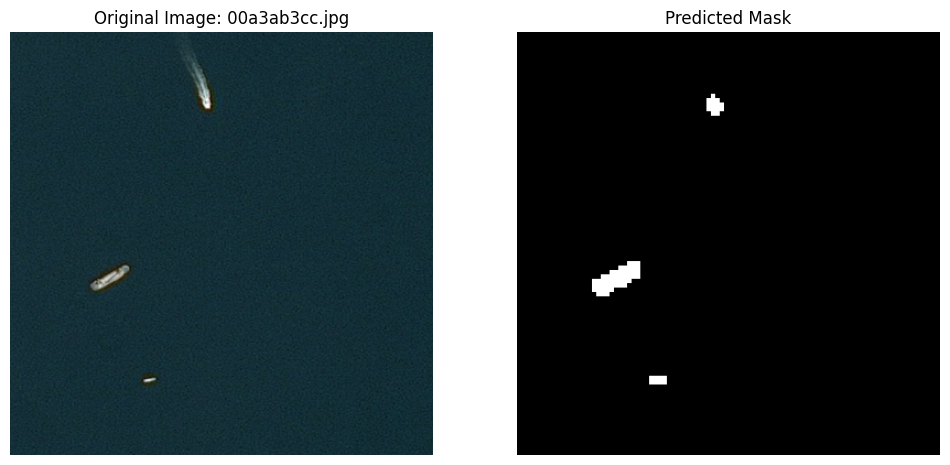

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


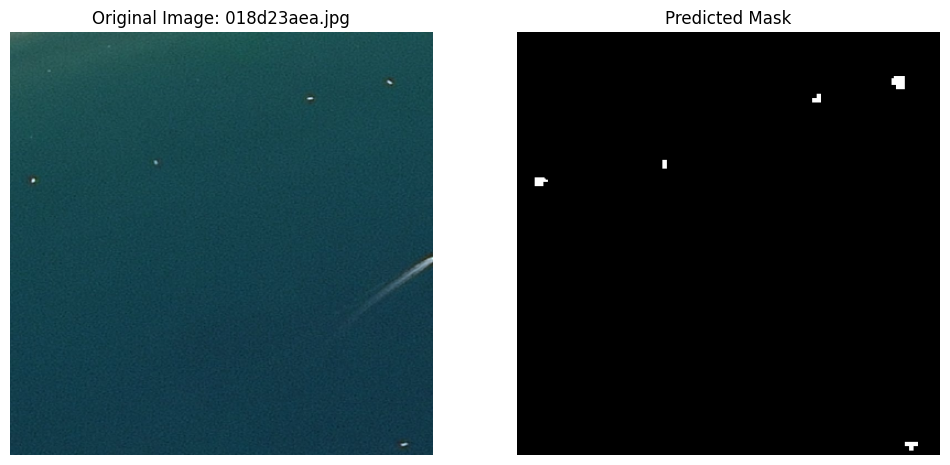

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


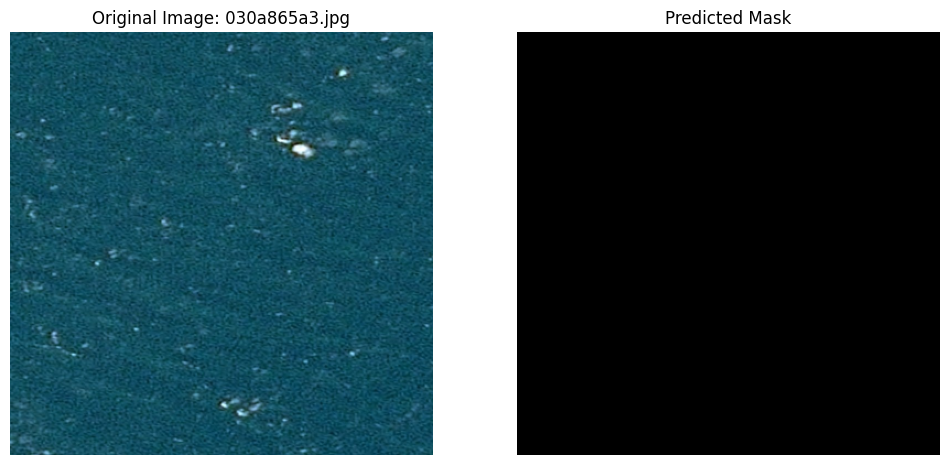

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


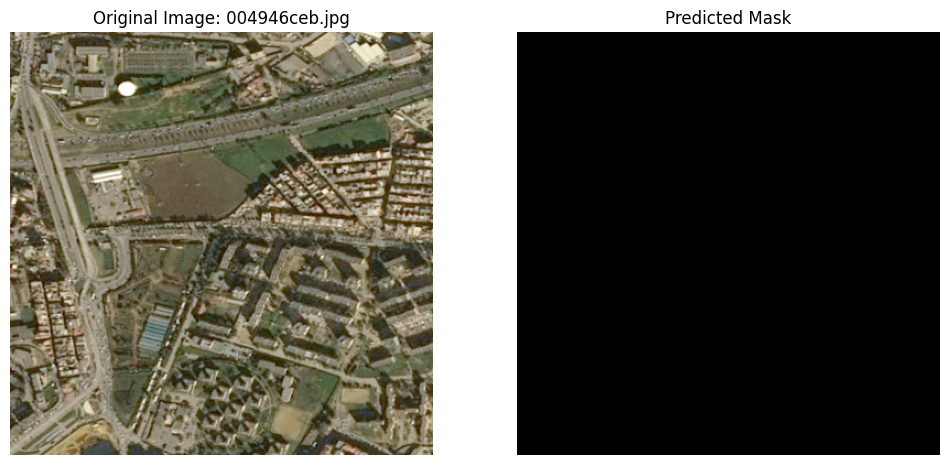

In [26]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the saved model
model = tf.keras.models.load_model('mask_rcnn_best_model.keras')

# List of image file names
image_names = [
    "000f7d875.jpg", "0035268d9.jpg",
    "00a3ab3cc.jpg", "018d23aea.jpg",
    "030a865a3.jpg","004946ceb.jpg"
]

# Path to the folder containing test images
image_folder = 'test_v2/'

# Function to preprocess the image and predict the mask
def visualize_predictions(image_name):
    image_path = image_folder + image_name
    image = cv2.imread(image_path)

    if image is None:
        print(f"Could not load image: {image_name}")
        return

    # Resize the image to the input shape the model expects
    image_resized = cv2.resize(image, (384, 384))

    # Normalize the image like we did during training
    image_resized = image_resized.astype(np.float32) / 255.0

    # Expand dimensions to add a batch axis
    image_input = np.expand_dims(image_resized, axis=0)

    # Make prediction
    predictions = model.predict(image_input)

    # Post-process predictions
    mask = predictions[0]
    mask = (mask > 0.2).astype(np.uint8)  # Convert to binary

    # Plot the original image and the predicted mask using plt
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Original image
    axes[0].imshow(cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB))
    axes[0].set_title(f"Original Image: {image_name}")
    axes[0].axis('off')

    # Predicted mask
    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title("Predicted Mask")
    axes[1].axis('off')

    plt.show()

# Loop through each image and visualize predictions
for image_name in image_names:
    visualize_predictions(image_name)

